In [261]:
# running pyspark locally
# setup instructions: https://sparkbyexamples.com/pyspark/install-pyspark-in-anaconda-jupyter-notebook/
import pyspark
import pandas as pd         
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession \
	    .builder \
	    .appName("NYC Covid-19 Transportation Analysis") \
	    .getOrCreate()

In [234]:
# load the csv file
subway2020 = spark.read.csv(path = '../data/subway/subway2020.csv', header = True)

In [235]:
# get rid of year that isn't 2020
subway2020 = subway2020.filter(substring(col("Date"), -4, 4).like("2020"))

In [236]:
# eliminate duplicated entries
subway2020 = subway2020.distinct()

In [237]:
# create a new column based on column 'C/A', 'Unit', and 'SCP' in order to uniquely identify a turnstile
subway2020 = subway2020.withColumn("TurnstileID", concat(col("C/A"), col("Unit"), col("SCP")))

In [240]:
# the entries value for a particular turnstile in a single date is recorded at 6 different time
# e.g.
# time   entries count
# 03:00 -> 7336735
# 07:00 -> 7336751
# 11:00 -> 7336881
# 15:00 -> 7337095
# 19:00 -> 7337862
# 23:00 -> 7338122

# quoting from https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
# "We also never allownet_entries or net_exits to be greater than 10,000. Because the 
# turnstile readings are like odometers, they can only count so high. When they roll over, 
# the result is astronomically large net values that need to be thrown out. 10,000 is a 
# reasonable cutoff for excluding these errant calculations, as it represents 2,500 persons per hour 
# passing through a turnstile, or 41 persons per minute"
dailyTurnstileEntryCount = (subway2020.groupBy("TurnstileID", "Date")
                             .agg((max("Entries") - min("Entries")).alias("dailyEntryCount"))
                             .filter(col("dailyEntryCount") <= 10000))

# examine the above calculation
# dailyTurnstileEntryCount.show(10)

In [241]:
# turnstile might get reset or malfunctions sometimes, therefore
# negative entry count may occur when max("Entries") is less than min("Entries")
# in order to ensure daily entry count is always positive, we are going to replace those
# negative count with 0
dailyTurnstileEntryCount = dailyTurnstileEntryCount.withColumn("dailyEntryCount", when(col("dailyEntryCount") >= 0, col("dailyEntryCount")).otherwise(0))

In [242]:
# we decide to add (dailyEntryCount / 6) for each entry count
# in order to account for the missing entry count before 3:00 and after 23:00
dailyTurnstileEntryCount = dailyTurnstileEntryCount.withColumn("adjustedDailyEntryCount", col("dailyEntryCount") + round(col("dailyEntryCount") / 6).cast("integer"))
dailyTurnstileEntryCount.show(10)

+----------------+----------+---------------+-----------------------+
|     TurnstileID|      Date|dailyEntryCount|adjustedDailyEntryCount|
+----------------+----------+---------------+-----------------------+
|A002R05102-00-00|01/01/2020|          462.0|                  539.0|
|A002R05102-00-00|01/09/2020|         1387.0|                 1618.0|
|A002R05102-00-00|01/21/2020|         1373.0|                 1602.0|
|A002R05102-00-00|01/23/2020|         1429.0|                 1667.0|
|A002R05102-00-00|01/27/2020|         1373.0|                 1602.0|
|A002R05102-00-00|02/01/2020|          729.0|                  851.0|
|A002R05102-00-00|02/10/2020|         1161.0|                 1355.0|
|A002R05102-00-00|02/12/2020|         1427.0|                 1665.0|
|A002R05102-00-00|02/13/2020|         1308.0|                 1526.0|
|A002R05102-00-00|02/15/2020|          696.0|                  812.0|
+----------------+----------+---------------+-----------------------+
only showing top 10 

In [243]:
# find the total daily entry count for each date in 2020
totalDailyEntries = dailyTurnstileEntryCount.groupBy("Date").agg(sum("adjustedDailyEntryCount").alias("totalDailyEntries"))

# sort the DataFrame by Date in ascending order
totalDailyEntries = totalDailyEntries.orderBy("Date")

In [244]:
totalDailyEntries.show()

+----------+-----------------+
|      Date|totalDailyEntries|
+----------+-----------------+
|01/01/2020|        2437909.0|
|01/02/2020|        5864837.0|
|01/03/2020|        5747122.0|
|01/04/2020|        3070880.0|
|01/05/2020|        2520360.0|
|01/06/2020|        6168727.0|
|01/07/2020|        6298641.0|
|01/08/2020|        6327321.0|
|01/09/2020|        6357183.0|
|01/10/2020|        6275697.0|
|01/11/2020|        3290674.0|
|01/12/2020|        2525751.0|
|01/13/2020|        6130304.0|
|01/14/2020|        6336358.0|
|01/15/2020|        6431844.0|
|01/16/2020|        6418277.0|
|01/17/2020|        6144215.0|
|01/18/2020|        2814782.0|
|01/19/2020|        2496024.0|
|01/20/2020|        3639560.0|
+----------+-----------------+
only showing top 20 rows



In [245]:
totalDailyEntries.count()

352

In [256]:
# carry out the above same operations to find the total daily entries count for 2019

# load the csv file
subway2019 = spark.read.csv(path = '../data/subway/subway2019.csv', header = True)

# get rid of year that isn't 2019
subway2019 = subway2019.filter(substring(col("Date"), -4, 4).like("2019"))

# eliminate duplicated entries
subway2019 = subway2019.distinct()

# create a new column based on column 'C/A', 'Unit', and 'SCP' in order to uniquely identify a turnstile
subway2019 = subway2019.withColumn("TurnstileID", concat(col("C/A"), col("Unit"), col("SCP")))

# find daily entry counts for each turnstile
dailyTurnstileEntryCount2019 = (subway2019.groupBy("TurnstileID", "Date")
                             .agg((max("Entries") - min("Entries")).alias("dailyEntryCount"))
                             .filter(col("dailyEntryCount") <= 10000))

# filter out negative daily entry count
dailyTurnstileEntryCount2019 = dailyTurnstileEntryCount2019.withColumn("dailyEntryCount", when(col("dailyEntryCount") >= 0, col("dailyEntryCount")).otherwise(0))

# adjust dailyEntryCount column's value due to potential missing counts before 3:00 and after 23:00 for each day
dailyTurnstileEntryCount2019 = dailyTurnstileEntryCount2019.withColumn("adjustedDailyEntryCount", col("dailyEntryCount") + round(col("dailyEntryCount") / 6).cast("integer"))

# find the total daily entry count for each date in 2019
totalDailyEntries2019 = dailyTurnstileEntryCount2019.groupBy("Date").agg(sum("adjustedDailyEntryCount").alias("totalDailyEntries"))

# sort the DataFrame by Date in ascending order
totalDailyEntries2019 = totalDailyEntries2019.orderBy("Date")

totalDailyEntries2019.show()

+----------+-----------------+
|      Date|totalDailyEntries|
+----------+-----------------+
|01/01/2019|        2369283.0|
|01/02/2019|        5994608.0|
|01/03/2019|        6247771.0|
|01/04/2019|        6156186.0|
|01/05/2019|        2854779.0|
|01/06/2019|        2471600.0|
|01/07/2019|        6149011.0|
|01/08/2019|        6256799.0|
|01/09/2019|        6403770.0|
|01/10/2019|        6384803.0|
|01/11/2019|        6196427.0|
|01/12/2019|        3018921.0|
|01/13/2019|        2319560.0|
|01/14/2019|        6163309.0|
|01/15/2019|        6385607.0|
|01/16/2019|        6442519.0|
|01/17/2019|        6461733.0|
|01/18/2019|        6056952.0|
|01/19/2019|        3003758.0|
|01/20/2019|        2094951.0|
+----------+-----------------+
only showing top 20 rows



In [257]:
totalDailyEntries2019.count()

340

In [283]:
dailyTripsCount2019 = list(totalDailyEntries2019.select(col("totalDailyEntries")).rdd.flatMap(lambda x: x).collect())
dailyTripsCount2020 = list(totalDailyEntries.select(col("totalDailyEntries")).rdd.flatMap(lambda x: x).collect())

In [284]:
# len dailyTripsCount2019: 340
# len dailyTripsCount2020: 352

# find the 7-day trips avgerage of 2019, using numpy's rolling function
tripsAvg2019 = pd.Series(dailyTripsCount2019).rolling(window=7).mean()
# convert tripsAvg2019 pandas series into list for future plotting purpose
tripsAvg2019 = tripsAvg2019.tolist()


# find the 7-day trips avgerage of 2020, using numpy's rolling function
tripsAvg2020 = pd.Series(dailyTripsCount2020).rolling(window=7).mean()
# convert tripsAvg2019 pandas series into list for future plotting purpose
tripsAvg2020 = tripsAvg2020.tolist()


for i in range(26):
    dailyTripsCount2019.append(np.nan)

for i in range(14):
    dailyTripsCount2020.append(np.nan)


import datetime
date_strings = [str(datetime.date(2020, 1, 1) + datetime.timedelta(days=i)) for i in range(366)]

In [287]:
for i in range(26):
    tripsAvg2019.append(np.nan)

for i in range(14):
    tripsAvg2020.append(np.nan)

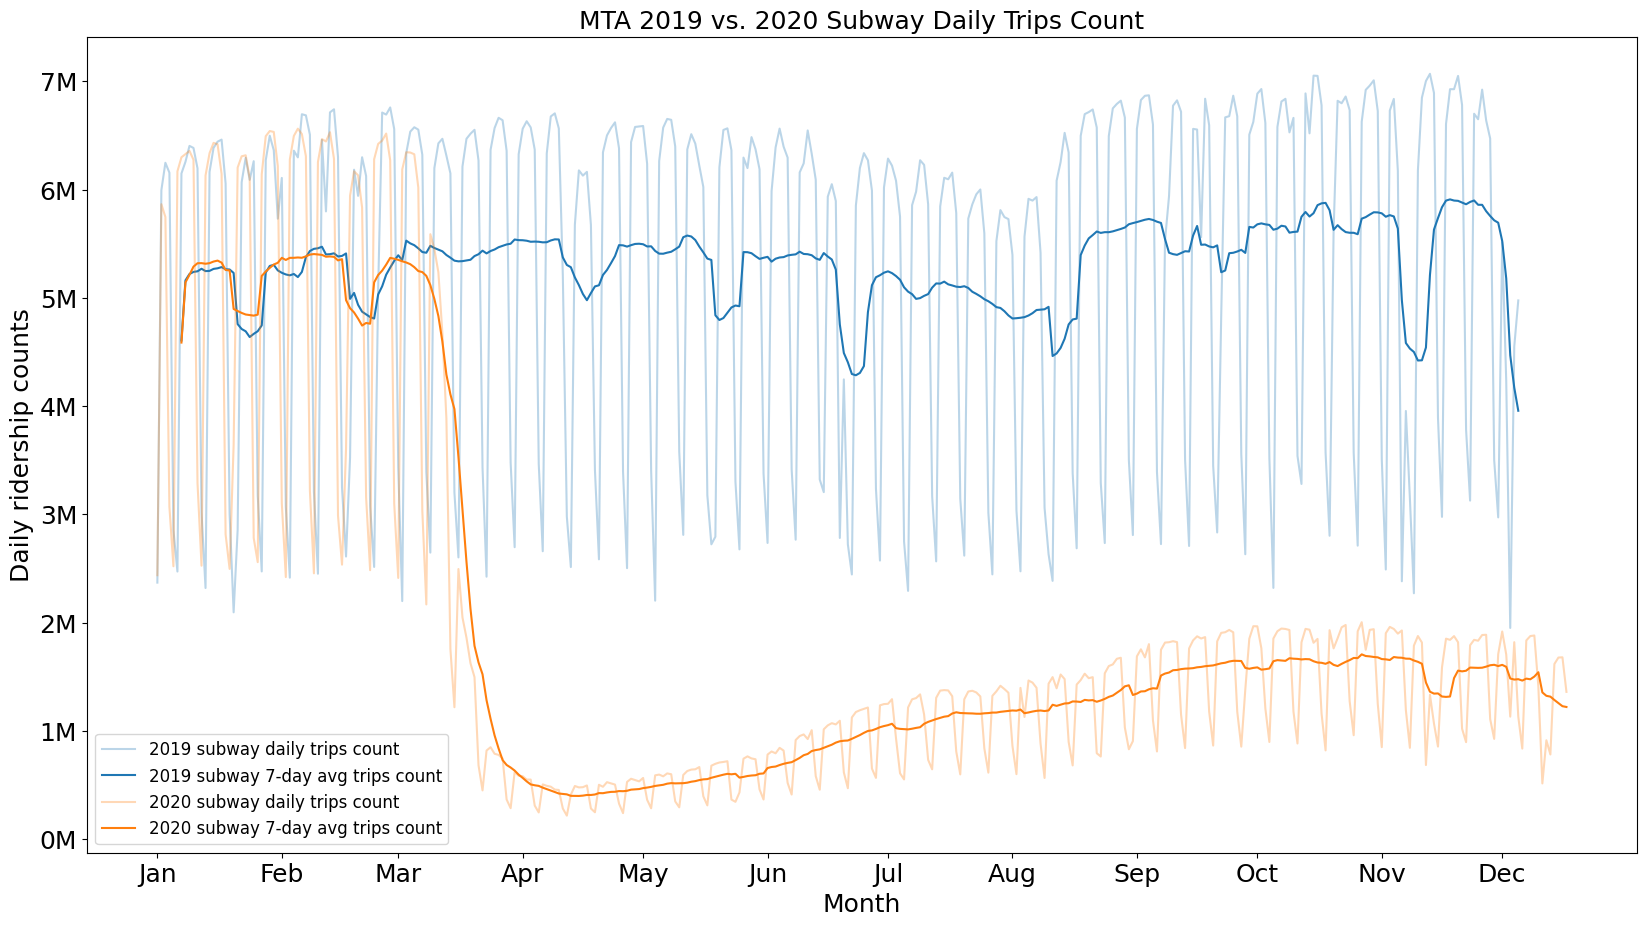

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 64603)
Traceback (most recent call last):
  File "/Users/jasonlai/opt/anaconda3/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/jasonlai/opt/anaconda3/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/jasonlai/opt/anaconda3/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/jasonlai/opt/anaconda3/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/jasonlai/opt/anaconda3/lib/python3.9/site-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/Users/jasonlai/opt/anaconda3/lib/python3.9/site-packages/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/Users/j

In [299]:
# set the size of the plot
plt.figure(figsize=(20, 12))

blue = u'#1f77b4'
orange = u'#ff7f0e'

# plot data
plt.plot(date_strings, dailyTripsCount2019, 
         label='2019 subway daily trips count', alpha = 0.3, color = blue)
plt.plot(date_strings, tripsAvg2019, 
         label='2019 subway 7-day avg trips count', color = blue)
plt.plot(date_strings, dailyTripsCount2020, 
         label='2020 subway daily trips count', alpha = 0.3, color = orange)
plt.plot(date_strings, tripsAvg2020, 
         label='2020 subway 7-day avg trips count', color = 'orange')
plt.legend(fontsize=12)

# set plot title and axis labels
plt.title('MTA 2019 vs. 2020 Subway Daily Trips Count', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Daily ridership counts', fontsize=18)

# set x-tick labels to show abbreviated month names
dateRange = pd.date_range(start='2020-01-01', end='2020-12-31')
monthStarts = [date for date in dateRange if date.day == 1]
daysSinceStartOfYear = [(date - pd.Timestamp(date.year, 1, 1)).days for date in monthStarts]
monthNames = [date.strftime('%b') for date in monthStarts]
plt.xticks(daysSinceStartOfYear, monthNames, fontsize=18)

# adjust plot margins
plt.subplots_adjust(bottom=0.20)

# set yticks fontsize
plt.yticks(fontsize=18)

# format y-tick labels as millions
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    """
    Formats y-tick labels as millions
    """
    return f'{x / 1e6:.0f}M'

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# show plot
plt.show()